## Homework 05:

## Due Date: Mar 15, 2021, 4:00pm

#### Firstname Lastname: Yuhan Liu

#### E-mail: yl7576@nyu.edu

#### Enter your solutions and submit this notebook

---

### Part of Lecture 04

---

In [122]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G

def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

# using iterators to traverse the grid
def iteration_gen(G):
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
    

# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

    
def solve_heat_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n) 
    set_boundary_grid(G)# G is boundary = 1, inside = 0
    
    G_prev = build_grid(n) # G_prev = all 0
    copy_array(G, G_prev) # G_prev = G => boundary = 1, inside = 0
    
    error = np.float("inf") # set a large number and get into loop
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

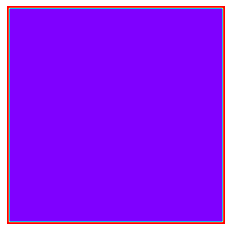

In [123]:
size_of_grid = 100
G = build_grid(n=size_of_grid)
set_boundary_grid(G)
plot_grid(G) 

In [124]:
%load_ext line_profiler
%lprun -f solve_heat_equation4 G4 = solve_heat_equation4(size_of_grid)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


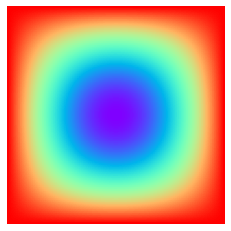

In [125]:
plot_grid(G4)


---

# Problem 1. (100 points)


In Lecture 04 we considered the heat equation over a homogeneous material for which an iteration is given by the following equation:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

This was implemented by: 
```
# using iterators to traverse the grid
def iteration_gen(G):
"""the iteration function from lect04"""
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
```


----

Now imagine, you are given a non-homogeneous material for which the iteration, i.e. the corresponding equation,  depends on the position $(i, j)$ and is given by:
$$
f_{i,j} := \frac{ h_{i + 1,j} f_{i + 1, j} + h_{i - 1,j} f_{i - 1,j} + h_{i,j + 1} f_{i,j+1} + h_{i,j - 1} f_{i,j-1}}{ h_{i + 1,j} + h_{i - 1,j} + h_{i,j + 1} + h_{i,j - 1} } \,.
$$
Here "weight"
$$h(i, j) = \exp\left(-\frac{|i - j|} {\sqrt{n}}\right) \,,$$
corresponds to the point $(i, j)$, where $n$ is the size of the grid.

----

Write a new function:
```
def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
```
to solve the non-homogeneous case defined as above. 


The task here is to examine run-time improvements that can be obtained by Cython for this non-homogeneous material. Consider **solve_heat_equation4** from Lect04, which now becomes.

```
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)
```

----

Concretely, as presented in Lect05, perform the following steps and measure their run-times:

(i) simply compile the python code with Cython, without any changes;


(ii) introduce variables and arrays with ctypes (by using the command cdef);  


(iii) besides (ii), also use the content of ndarray objects in order to efficiently access the data buffer of the arrays.

---

In the sequel of the notebook, as your solution, submit codes, run-times, and plots of the following tasks:

**2.1 (30pt)** solve_heat_nonhomogeneous_equation4(100)

**2.2 (10pt)** solve_heat_nonhomogeneous_equation4(100) when applied (i)  

**2.3 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (ii)  

**2.4 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (iii)  

Notice that to obtain a best performance for the heat equation you also need to apply (i), (ii), (iii) to the functions called within "solve_heat_equation4".


In [126]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [127]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [128]:
size_of_grid = 100

### Part 1: solve_heat_equation4(100)

In [130]:
import math

def iteration_gen_nonhomogeneous(G):
    def hij(i,j):
        return math.exp(-abs(i-j)/math.sqrt(size_of_grid))
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        h1 = hij(e[0] + 1, e[1]) 
        h2 = hij(e[0] - 1, e[1]) 
        h3 = hij(e[0], e[1] + 1) 
        h4 = hij(e[0], e[1] - 1)
        G[e]=(h1*G[e[0] + 1, e[1]] + h2*G[e[0] - 1, e[1]] + h3*G[e[0], e[1] + 1] + h4*G[e[0], e[1] - 1])/(h1+h2+h3+h4)

def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

In [ ]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:


Timer unit: 1e-06 s

Total time: 22.6371 s
File: <ipython-input-111-3f69a745897d>
Function: solve_heat_nonhomogeneous_equation4 at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    15                                           def solve_heat_nonhomogeneous_equation4(n):
    16                                               '''changing to both calc_error_np and iteration_gen functions'''
    17         1         22.0     22.0      0.0      G = build_grid(n)
    18         1         19.0     19.0      0.0      set_boundary_grid(G)
    19                                           
    20         1         10.0     10.0      0.0      G_prev = build_grid(n)
    21         1        282.0    282.0      0.0      copy_array(G, G_prev)
    22                                           
    23         1          5.0      5.0      0.0      error = np.float("inf")
    24       310        316.0      1.0      0.0      while error > 1e-7:
    25       309   22611675.0  73176.9     99.9          iteration_gen_nonhomogeneous(G)
    26       309      21917.0     70.9      0.1          error = calc_error_np(G, G_prev) 
    27       309       2898.0      9.4      0.0          copy_array(G, G_prev)          
    28         1          0.0      0.0      0.0      return(G)

### Part 2: solve_heat_equation4(100) after applying (i)


In [117]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [118]:
%reload_ext Cython

In [120]:
%%cython
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import math

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G

def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

def iteration_gen_nonhomogeneous(G):
    def hij(i,j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
    
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    for e in indices:
        h1 = hij(e[0] + 1, e[1]) 
        h2 = hij(e[0] - 1, e[1]) 
        h3 = hij(e[0], e[1] + 1) 
        h4 = hij(e[0], e[1] - 1)
        G[e]=(h1*G[e[0] + 1, e[1]] + h2*G[e[0] - 1, e[1]] + h3*G[e[0], e[1] + 1] + h4*G[e[0], e[1] - 1])/(h1+h2+h3+h4)

def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]
    
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return G


Error compiling Cython file:
------------------------------------------------------------
...
    plt.axis('off')
    plt.show()

def iteration_gen_nonhomogeneous(G):
    def hij(i,j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
                                             ^
------------------------------------------------------------

/Users/yuhanliu/.ipython/cython/_cython_magic_d496f2e98ef6fc45f8affd4a835b2d11.pyx:32:46: undeclared name not builtin: size_of_grid


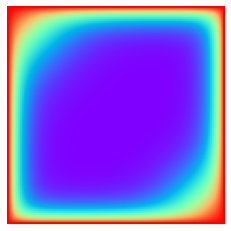

In [103]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

Total time: 32.3507 s
File: /Users/yuhanliu/.ipython/cython/_cython_magic_6ac345ab6ec69890c9fb34b1a5170755.pyx
Function: solve_heat_nonhomogeneous_equation4 at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    52                                           def solve_heat_nonhomogeneous_equation4(n):
    53                                               '''changing to both calc_error_np and iteration_gen functions'''
    54         1         25.0     25.0      0.0      G = build_grid(n)
    55         1         20.0     20.0      0.0      set_boundary_grid(G)
    56                                           
    57         1        265.0    265.0      0.0      G_prev = build_grid(n)
    58         1       1214.0   1214.0      0.0      copy_array(G, G_prev)
    59                                           
    60         1          7.0      7.0      0.0      error = np.float("inf")
    61         1          1.0      1.0      0.0      while error > 1e-7:
    62       309   32308488.0 104558.2     99.9          iteration_gen_nonhomogeneous(G)
    63       309      36703.0    118.8      0.1          error = calc_error_np(G, G_prev) 
    64       309       3961.0     12.8      0.0          copy_array(G, G_prev)          
    65         1         12.0     12.0      0.0      return(G)

### Part 3: solve_heat_equation4(100) after applying (ii)

#### <font color='black'>Basic C Types</font>
| Type        |	Description |
| :---        | :---: |
| char	| 8-bit signed integer |
| short	| 16-bit signed integer |
|int	| 32-bit signed integer |
| long	| 64-bit signed integer |
| float	| 32-bit floating point |
| double |64-bit floating point |
| long double | 80-bit floating point |<br>
#### <font color='blue'>Array</font>
type name[size]
#### <font color='blue'>Pointer</font>
type* name
#### <font color='blue'>Structure</font>
struct name { declaration }

In [104]:
%%cython 
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import math

def build_grid(int n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G

def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

def hij(i,j,n):
    return math.exp(-abs(i-j)/np.sqrt(n))

def iteration_gen_nonhomogeneous(G):
    def hij(i,j,n):
        return math.exp(-abs(i-j)/np.sqrt(n))
    
    int n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    for e in indices:
        h1 = hij(e[0] + 1, e[1], n) 
        h2 = hij(e[0] - 1, e[1], n) 
        h3 = hij(e[0], e[1] + 1, n) 
        h4 = hij(e[0], e[1] - 1, n)
        G[e]=(h1*G[e[0] + 1, e[1]] + h2*G[e[0] - 1, e[1]] + h3*G[e[0], e[1] + 1] + h4*G[e[0], e[1] - 1])/(h1+h2+h3+h4)
    
# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]
    
def solve_heat_nonhomogeneous_equation4(int n):
    '''changing to both calc_error_np and iteration_gen functions'''
    #cdef int n
    cdef np.ndarray G = build_grid(n)
    set_boundary_grid(G)

    cdef np.ndarray G_prev = build_grid(n)
    copy_array(G, G_prev)

    cdef float error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)


Error compiling Cython file:
------------------------------------------------------------
...
    G2[:, :] = G1[:, :]
    
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    #cdef int n
    cdef np.ndarray G = build_grid(n)
        ^
------------------------------------------------------------

/Users/yuhanliu/.ipython/cython/_cython_magic_aa5b4c89c3a29b84cef7fbaad85ebfb0.pyx:54:9: 'np' is not a cimported module

Error compiling Cython file:
------------------------------------------------------------
...
    '''changing to both calc_error_np and iteration_gen functions'''
    #cdef int n
    cdef np.ndarray G = build_grid(n)
    set_boundary_grid(G)

    cdef np.ndarray G_prev = build_grid(n)
        ^
------------------------------------------------------------

/Users/yuhanliu/.ipython/cython/_cython_magic_aa5b4c89c3a29b84cef7fbaad85ebfb0.pyx:57:9: 'np' is not a cimported module


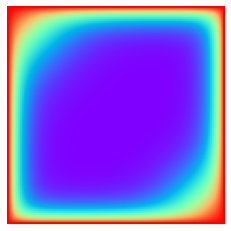

In [79]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

Total time: 35.9497 s
File: <ipython-input-73-55a7ef3b79e3>
Function: solve_heat_nonhomogeneous_equation4 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def solve_heat_nonhomogeneous_equation4(n):
     2                                               '''changing to both calc_error_np and iteration_gen functions'''
     3         1         46.0     46.0      0.0      G = build_grid(n)
     4         1         25.0     25.0      0.0      set_boundary_grid(G)
     5                                           
     6         1          6.0      6.0      0.0      G_prev = build_grid(n)
     7         1         11.0     11.0      0.0      copy_array(G, G_prev)
     8                                           
     9         1          4.0      4.0      0.0      error = np.float("inf")
    10       310        341.0      1.1      0.0      while error > 1e-7:
    11       309   35921404.0 116250.5     99.9          iteration_gen_nonhomogeneous(G)
    12       309      24605.0     79.6      0.1          error = calc_error_np(G, G_prev) 
    13       309       3262.0     10.6      0.0          copy_array(G, G_prev)          
    14         1          1.0      1.0      0.0      return(G)

### Part 4: solve_heat_equation4(100) after applying (iii)

In [ ]:
%lprun -f solve_heat_nonhomogenous_equation4 G = solve_heat_nonhomogenous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER: